# Import modules

In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV

# EDA

### Read CSV

In [155]:
accu_df = pd.read_csv("Datasets\synthetic_accural_data.csv")
redm_df = pd.read_csv("Datasets\synthetic_redeem_data.csv")

In [156]:
accu_df.head()

,transaction_id,customer_unique_id,transaction_date,transaction_type,points,partner_id,store_id,opening_balance,closing_balance,amount,is_anomaly,anomaly_types,country_code,activity_id,category_code,sku_category_code,item_code,quantity,created_at,updated_at,bill_date,business_date,rule_id,rule_type,payment_type,program_id,program_country,program_currency,base_currency,trans_currency,conversion_rate,amount_in_trans_currency,usd_conversion_rate,amount_in_usd,channel_code,point_expiry,funding_partner_id,point_type_id,calculated_amount
0,TXN00002862,0006417714fe4a78913920f39a03cdf7,2023-01-06 07:30:00.000000,earn,333.09,439,3896,0.00,333.09,2307.33,0,NaN,971,186,ELEC,SKU-A1,ITM6791,6,2023-01-05 07:30:00.000000,2023-01-08 07:30:00.000000,2023-01-04 07:30:00.000000,2023-01-04 07:30:00.000000,10,base,CASH,3,65,USD,USD,USD,0.6737,1554.45,0.0805,185.74,CPN,2023-06-05 07:30:00.000000,439,9,2217.93
1,TXN00002863,0006417714fe4a78913920f39a03cdf7,2023-01-08 06:19:00.000000,earn,314.54,439,3025,333.09,647.63,4863.34,0,NaN,91,232,ELEC,SKU-C3,ITM5485,7,2023-01-07 06:19:00.000000,2023-01-08 06:19:00.000000,2023-01-07 06:19:00.000000,2023-01-05 06:19:00.000000,43,base,CASH,18,91,INR,USD,INR,0.9181,4465.03,0.0969,471.26,CPN,2024-11-02 06:19:00.000000,439,13,4883.89
2,TXN00002864,0006417714fe4a78913920f39a03cdf7,2023-01-09 10:06:00.000000,earn,341.69,212,4950,647.63,989.32,644.58,0,NaN,65,429,HM45,SKU-B2,ITM5940,9,2023-01-06 10:06:00.000000,2023-01-10 10:06:00.000000,2023-01-07 10:06:00.000000,2023-01-06 10:06:00.000000,3,base,CARD,25,65,SGD,USD,SGD,0.6280,404.80,0.0687,44.28,POS,2023-12-29 10:06:00.000000,212,19,604.63
3,TXN00002866,0006417714fe4a78913920f39a03cdf7,2023-01-11 08:48:00.000000,earn,274.21,439,1144,660.26,934.47,3202.35,0,NaN,91,297,ELEC,SKU-B2,ITM5806,4,2023-01-08 08:48:00.000000,2023-01-13 08:48:00.000000,2023-01-08 08:48:00.000000,2023-01-08 08:48:00.000000,41,base,WALLET,13,971,AED,USD,AED,1.1400,3650.68,0.0767,245.62,POS,2024-10-30 08:48:00.000000,439,15,3627.60
4,TXN00002868,0006417714fe4a78913920f39a03cdf7,2023-01-13 08:15:00.000000,earn,350.79,439,1145,885.07,1235.86,4056.82,0,NaN,91,314,FASHX,SKU-A1,ITM2370,6,2023-01-11 08:15:00.000000,2023-01-13 08:15:00.000000,2023-01-10 08:15:00.000000,2023-01-10 08:15:00.000000,32,base,CARD,1,65,AED,USD,AED,1.2190,4945.26,0.0618,250.71,CPN,2023-12-27 08:15:00.000000,439,3,4557.73


In [157]:
redm_df.head()

,transaction_id,customer_unique_id,transaction_date,transaction_type,points,partner_id,store_id,opening_balance,closing_balance,amount,is_anomaly,anomaly_types,country_code,activity_id,category_code,sku_category_code,item_code,quantity,created_at,updated_at,bill_date,business_date,rule_id,rule_type,payment_type,program_id,program_country,program_currency,base_currency,trans_currency,conversion_rate,amount_in_trans_currency,usd_conversion_rate,amount_in_usd,channel_code,point_expiry,funding_partner_id,point_type_id,calculated_amount
0,TXN00002865,0006417714fe4a78913920f39a03cdf7,2023-01-10 06:39:00.000000,redeem,329.06,439,4201,989.32,660.26,2309.53,0,NaN,1,175,HM45,SKU-A1,ITM7103,8,2023-01-09 06:39:00.000000,2023-01-12 06:39:00.000000,2023-01-07 06:39:00.000000,2023-01-07 06:39:00.000000,36,base,CASH,27,65,INR,USD,INR,1.5147,3498.25,0.0457,105.55,CPN,2024-12-22 06:39:00.000000,439,18,2016.54
1,TXN00002867,0006417714fe4a78913920f39a03cdf7,2023-01-12 11:57:00.000000,redeem,49.40,439,3571,934.47,885.07,2484.20,0,NaN,1,356,HM45,SKU-B2,ITM7192,1,2023-01-10 11:57:00.000000,2023-01-13 11:57:00.000000,2023-01-10 11:57:00.000000,2023-01-11 11:57:00.000000,33,promo,UPI,23,971,INR,USD,INR,0.8328,2068.84,0.0509,126.45,CPN,2024-05-12 11:57:00.000000,439,7,2087.11
2,TXN00005307,002cc23bffa546f1b6135d696f7ee2f8,2023-01-09 19:05:00.000000,redeem,312.96,435,2112,459.79,146.83,1893.40,0,NaN,1,490,GROC123,SKU-C3,ITM7112,5,2023-01-07 19:05:00.000000,2023-01-09 19:05:00.000000,2023-01-06 19:05:00.000000,2023-01-08 19:05:00.000000,33,promo,WALLET,5,1,INR,USD,INR,1.1529,2182.90,0.0495,93.72,POS,2024-07-24 19:05:00.000000,435,7,1596.01
3,TXN00005310,002cc23bffa546f1b6135d696f7ee2f8,2023-01-13 21:39:00.000000,redeem,37.73,435,2473,740.86,703.13,4298.60,0,NaN,971,285,FASHX,SKU-A1,ITM3385,5,2023-01-12 21:39:00.000000,2023-01-13 21:39:00.000000,2023-01-12 21:39:00.000000,2023-01-10 21:39:00.000000,49,promo,CASH,24,1,SGD,USD,SGD,0.8989,3864.01,0.0794,341.31,POS,2023-10-18 21:39:00.000000,435,1,4166.84
4,TXN00005311,002cc23bffa546f1b6135d696f7ee2f8,2023-01-15 19:38:00.000000,redeem,87.01,435,1948,703.13,616.12,4442.77,0,NaN,65,105,GROC123,SKU-A1,ITM5996,6,2023-01-13 19:38:00.000000,2023-01-15 19:38:00.000000,2023-01-13 19:38:00.000000,2023-01-12 19:38:00.000000,39,base,CARD,19,1,USD,USD,USD,1.8908,8400.39,0.0416,184.82,CPN,2023-04-11 19:38:00.000000,435,14,3787.68


In [158]:
accu_df.dtypes

transaction_id                  str
customer_unique_id              str
transaction_date                str
transaction_type                str
points                      float64
partner_id                    int64
store_id                      int64
opening_balance             float64
closing_balance             float64
amount                      float64
is_anomaly                    int64
anomaly_types                   str
country_code                  int64
activity_id                   int64
category_code                   str
sku_category_code               str
item_code                       str
quantity                      int64
created_at                      str
updated_at                      str
bill_date                       str
business_date                   str
rule_id                       int64
rule_type                       str
payment_type                    str
program_id                    int64
program_country               int64
program_currency            

In [159]:
redm_df.dtypes

transaction_id                  str
customer_unique_id              str
transaction_date                str
transaction_type                str
points                      float64
partner_id                    int64
store_id                      int64
opening_balance             float64
closing_balance             float64
amount                      float64
is_anomaly                    int64
anomaly_types                   str
country_code                  int64
activity_id                   int64
category_code                   str
sku_category_code               str
item_code                       str
quantity                      int64
created_at                      str
updated_at                      str
bill_date                       str
business_date                   str
rule_id                       int64
rule_type                       str
payment_type                    str
program_id                    int64
program_country               int64
program_currency            

# Feature Engineering

### Drop unecessary column

In [160]:
columns_to_drop = [
    'transaction_id',
    'customer_unique_id',
    'anomaly_types',
    'created_at',
    'updated_at',
    'bill_date',
    'business_date',
    'rule_id',
    'rule_type',
    'item_code',
    'sku_category_code',
    'category_code',
    'store_id',
    'activity_id',
    'funding_partner_id'
]


In [161]:
print("Accrual DataFrame - Before drop:")
print(f"Shape: {accu_df.shape}")
print(f"Columns: {list(accu_df.columns)}")

accu_df = accu_df.drop(columns=columns_to_drop)

print("\nAccrual DataFrame - After drop:")
print(f"Shape: {accu_df.shape}")
print(f"Columns: {list(accu_df.columns)}")

print("\n" + "=" * 80)
print("Redeem DataFrame - Before drop:")
print(f"Shape: {redm_df.shape}")
print(f"Columns: {list(redm_df.columns)}")

redm_df = redm_df.drop(columns=columns_to_drop)

print("\nRedeem DataFrame - After drop:")
print(f"Shape: {redm_df.shape}")
print(f"Columns: {list(redm_df.columns)}")

Accrual DataFrame - Before drop:
Shape: (8219, 39)
Columns: ['transaction_id', 'customer_unique_id', 'transaction_date', 'transaction_type', 'points', 'partner_id', 'store_id', 'opening_balance', 'closing_balance', 'amount', 'is_anomaly', 'anomaly_types', 'country_code', 'activity_id', 'category_code', 'sku_category_code', 'item_code', 'quantity', 'created_at', 'updated_at', 'bill_date', 'business_date', 'rule_id', 'rule_type', 'payment_type', 'program_id', 'program_country', 'program_currency', 'base_currency', 'trans_currency', 'conversion_rate', 'amount_in_trans_currency', 'usd_conversion_rate', 'amount_in_usd', 'channel_code', 'point_expiry', 'funding_partner_id', 'point_type_id', 'calculated_amount']

Accrual DataFrame - After drop:
Shape: (8219, 24)
Columns: ['transaction_date', 'transaction_type', 'points', 'partner_id', 'opening_balance', 'closing_balance', 'amount', 'is_anomaly', 'country_code', 'quantity', 'payment_type', 'program_id', 'program_country', 'program_currency', '

### Convert date into hours, day of week, is weekend

In [162]:
print(f"Before: {accu_df.shape}")
print(f"Columns with 'date' in name: {[col for col in accu_df.columns if 'date' in col.lower()]}")

print(f"Before: {redm_df.shape}")
print(f"Columns with 'date' in name: {[col for col in redm_df.columns if 'date' in col.lower()]}")


Before: (8219, 24)
Columns with 'date' in name: ['transaction_date']
Before: (2364, 24)
Columns with 'date' in name: ['transaction_date']


In [163]:
accu_df['transaction_date'] = pd.to_datetime(accu_df['transaction_date'])

accu_df['hour'] = accu_df['transaction_date'].dt.hour
accu_df['day_of_week'] = accu_df['transaction_date'].dt.dayofweek 
accu_df['is_weekend'] = (accu_df['day_of_week'].isin([5, 6])).astype(int)

accu_df = accu_df.drop(columns=['transaction_date'])

print(f"After: {accu_df.shape}")
print(f"New columns added: hour, day_of_week, is_weekend")
print(f"Columns: {list(accu_df.columns)}")

redm_df['transaction_date'] = pd.to_datetime(redm_df['transaction_date'])

redm_df['hour'] = redm_df['transaction_date'].dt.hour
redm_df['day_of_week'] = redm_df['transaction_date'].dt.dayofweek 
redm_df['is_weekend'] = (redm_df['day_of_week'].isin([5, 6])).astype(int)

redm_df = redm_df.drop(columns=['transaction_date'])

print(f"After: {redm_df.shape}")
print(f"New columns added: hour, day_of_week, is_weekend")
print(f"Columns: {list(redm_df.columns)}")

print("Accrual:")
print(accu_df.head())
print("\nRedeem:")
print(redm_df.head())


After: (8219, 26)
New columns added: hour, day_of_week, is_weekend
Columns: ['transaction_type', 'points', 'partner_id', 'opening_balance', 'closing_balance', 'amount', 'is_anomaly', 'country_code', 'quantity', 'payment_type', 'program_id', 'program_country', 'program_currency', 'base_currency', 'trans_currency', 'conversion_rate', 'amount_in_trans_currency', 'usd_conversion_rate', 'amount_in_usd', 'channel_code', 'point_expiry', 'point_type_id', 'calculated_amount', 'hour', 'day_of_week', 'is_weekend']
After: (2364, 26)
New columns added: hour, day_of_week, is_weekend
Columns: ['transaction_type', 'points', 'partner_id', 'opening_balance', 'closing_balance', 'amount', 'is_anomaly', 'country_code', 'quantity', 'payment_type', 'program_id', 'program_country', 'program_currency', 'base_currency', 'trans_currency', 'conversion_rate', 'amount_in_trans_currency', 'usd_conversion_rate', 'amount_in_usd', 'channel_code', 'point_expiry', 'point_type_id', 'calculated_amount', 'hour', 'day_of_wee

In [164]:
redm_df.head()

,transaction_type,points,partner_id,opening_balance,closing_balance,amount,is_anomaly,country_code,quantity,payment_type,program_id,program_country,program_currency,base_currency,trans_currency,conversion_rate,amount_in_trans_currency,usd_conversion_rate,amount_in_usd,channel_code,point_expiry,point_type_id,calculated_amount,hour,day_of_week,is_weekend
0,redeem,329.06,439,989.32,660.26,2309.53,0,1,8,CASH,27,65,INR,USD,INR,1.5147,3498.25,0.0457,105.55,CPN,2024-12-22 06:39:00.000000,18,2016.54,6,1,0
1,redeem,49.40,439,934.47,885.07,2484.20,0,1,1,UPI,23,971,INR,USD,INR,0.8328,2068.84,0.0509,126.45,CPN,2024-05-12 11:57:00.000000,7,2087.11,11,3,0
2,redeem,312.96,435,459.79,146.83,1893.40,0,1,5,WALLET,5,1,INR,USD,INR,1.1529,2182.90,0.0495,93.72,POS,2024-07-24 19:05:00.000000,7,1596.01,19,0,0
3,redeem,37.73,435,740.86,703.13,4298.60,0,971,5,CASH,24,1,SGD,USD,SGD,0.8989,3864.01,0.0794,341.31,POS,2023-10-18 21:39:00.000000,1,4166.84,21,4,0
4,redeem,87.01,435,703.13,616.12,4442.77,0,65,6,CARD,19,1,USD,USD,USD,1.8908,8400.39,0.0416,184.82,CPN,2023-04-11 19:38:00.000000,14,3787.68,19,6,1


# Train, Test, Split

In [165]:
accu_y = accu_df["is_anomaly"]
redm_y = redm_df["is_anomaly"]

In [166]:
accu_X = accu_df.drop(columns=["is_anomaly"])
redm_X = redm_df.drop(columns=["is_anomaly"])

In [167]:
redm_X.head()

,transaction_type,points,partner_id,opening_balance,closing_balance,amount,country_code,quantity,payment_type,program_id,program_country,program_currency,base_currency,trans_currency,conversion_rate,amount_in_trans_currency,usd_conversion_rate,amount_in_usd,channel_code,point_expiry,point_type_id,calculated_amount,hour,day_of_week,is_weekend
0,redeem,329.06,439,989.32,660.26,2309.53,1,8,CASH,27,65,INR,USD,INR,1.5147,3498.25,0.0457,105.55,CPN,2024-12-22 06:39:00.000000,18,2016.54,6,1,0
1,redeem,49.40,439,934.47,885.07,2484.20,1,1,UPI,23,971,INR,USD,INR,0.8328,2068.84,0.0509,126.45,CPN,2024-05-12 11:57:00.000000,7,2087.11,11,3,0
2,redeem,312.96,435,459.79,146.83,1893.40,1,5,WALLET,5,1,INR,USD,INR,1.1529,2182.90,0.0495,93.72,POS,2024-07-24 19:05:00.000000,7,1596.01,19,0,0
3,redeem,37.73,435,740.86,703.13,4298.60,971,5,CASH,24,1,SGD,USD,SGD,0.8989,3864.01,0.0794,341.31,POS,2023-10-18 21:39:00.000000,1,4166.84,21,4,0
4,redeem,87.01,435,703.13,616.12,4442.77,65,6,CARD,19,1,USD,USD,USD,1.8908,8400.39,0.0416,184.82,CPN,2023-04-11 19:38:00.000000,14,3787.68,19,6,1


### Seperate categorical column

In [168]:
cal_cols_accu = accu_X.select_dtypes(include=['str','object']).columns
cal_cols_redm = redm_X.select_dtypes(include=['str','object']).columns

print(f'accu_cat_columns {cal_cols_accu}')
print(f'redm_cat_columns {cal_cols_redm}')


accu_cat_columns Index(['transaction_type', 'payment_type', 'program_currency', 'base_currency',
       'trans_currency', 'channel_code', 'point_expiry'],
      dtype='str')
redm_cat_columns Index(['transaction_type', 'payment_type', 'program_currency', 'base_currency',
       'trans_currency', 'channel_code', 'point_expiry'],
      dtype='str')


In [169]:
# check class imbalance
print(sum(accu_y)/len(accu_y))
print(sum(redm_y)/len(redm_y))

0.19199415987346394
0.30752961082910324


In [170]:
accu_neg = (accu_y == 0).sum()
accu_pos = (accu_y == 1).sum()
accu_scale_weight = accu_neg / accu_pos

print(f'accu_scale_weight: {accu_scale_weight}')

redm_neg = (redm_y == 0).sum()
redm_pos = (redm_y == 1).sum()
redm_scale_weight = redm_neg / redm_pos

print(f'redm_scale_weight: {redm_scale_weight}')

accu_scale_weight: 4.2084917617237005
redm_scale_weight: 2.25171939477304


In [171]:
accu_X_train, accu_X_test, accu_y_train, accu_y_test = train_test_split(accu_X, accu_y, test_size=0.2, stratify=accu_y, random_state=42)
redm_X_train, redm_X_test, redm_y_train, redm_y_test = train_test_split(redm_X, redm_y, test_size=0.2, stratify=redm_y, random_state=42)

# Train Model

### Without paramters

In [190]:
accu_model = CatBoostClassifier(
    class_weights=[1, accu_scale_weight]
)

redm_model = CatBoostClassifier(
    class_weights=[1, redm_scale_weight]
)

In [191]:
accu_model.fit(accu_X_train, accu_y_train, cat_features=cal_cols_accu.tolist())

Learning rate set to 0.023024
0:	learn: 0.6784318	total: 106ms	remaining: 1m 45s
1:	learn: 0.6649703	total: 185ms	remaining: 1m 32s
2:	learn: 0.6555836	total: 257ms	remaining: 1m 25s
3:	learn: 0.6440287	total: 347ms	remaining: 1m 26s
4:	learn: 0.6363155	total: 400ms	remaining: 1m 19s
5:	learn: 0.6299533	total: 473ms	remaining: 1m 18s
6:	learn: 0.6213781	total: 561ms	remaining: 1m 19s
7:	learn: 0.6148006	total: 660ms	remaining: 1m 21s
8:	learn: 0.6065760	total: 750ms	remaining: 1m 22s
9:	learn: 0.5973145	total: 845ms	remaining: 1m 23s
10:	learn: 0.5879474	total: 929ms	remaining: 1m 23s
11:	learn: 0.5773150	total: 1.02s	remaining: 1m 23s
12:	learn: 0.5702497	total: 1.1s	remaining: 1m 23s
13:	learn: 0.5636127	total: 1.19s	remaining: 1m 23s
14:	learn: 0.5565497	total: 1.29s	remaining: 1m 24s
15:	learn: 0.5507607	total: 1.36s	remaining: 1m 23s
16:	learn: 0.5452450	total: 1.43s	remaining: 1m 22s
17:	learn: 0.5362039	total: 1.51s	remaining: 1m 22s
18:	learn: 0.5302507	total: 1.59s	remaining: 

In [192]:
redm_model.fit(redm_X_train, redm_y_train, cat_features=cal_cols_redm.tolist())

Learning rate set to 0.013523
0:	learn: 0.6881006	total: 76.5ms	remaining: 1m 16s
1:	learn: 0.6839128	total: 122ms	remaining: 1m
2:	learn: 0.6803396	total: 173ms	remaining: 57.5s
3:	learn: 0.6774051	total: 250ms	remaining: 1m 2s
4:	learn: 0.6743746	total: 314ms	remaining: 1m 2s
5:	learn: 0.6695842	total: 381ms	remaining: 1m 3s
6:	learn: 0.6650225	total: 444ms	remaining: 1m 3s
7:	learn: 0.6616180	total: 524ms	remaining: 1m 5s
8:	learn: 0.6591421	total: 579ms	remaining: 1m 3s
9:	learn: 0.6561317	total: 661ms	remaining: 1m 5s
10:	learn: 0.6542314	total: 733ms	remaining: 1m 5s
11:	learn: 0.6510971	total: 805ms	remaining: 1m 6s
12:	learn: 0.6484669	total: 864ms	remaining: 1m 5s
13:	learn: 0.6451190	total: 918ms	remaining: 1m 4s
14:	learn: 0.6420685	total: 989ms	remaining: 1m 4s
15:	learn: 0.6390515	total: 1.08s	remaining: 1m 6s
16:	learn: 0.6361542	total: 1.15s	remaining: 1m 6s
17:	learn: 0.6336613	total: 1.25s	remaining: 1m 8s
18:	learn: 0.6312472	total: 1.31s	remaining: 1m 7s
19:	learn: 0

In [175]:
accu_y_pred = accu_model.predict(accu_X_test)
redm_y_pred = redm_model.predict(redm_X_test)

print(f'accuracy for accu_model: {accuracy_score(accu_y_test, accu_y_pred)}')
print(f'accuracy for redm_model: {accuracy_score(redm_y_test, redm_y_pred)}')

accuracy for accu_model: 0.8838199513381995
accuracy for redm_model: 0.7441860465116279


In [176]:
print(f'classification report for accu_model: \n {classification_report(accu_y_test, accu_y_pred)}')
print(f'classification report for redm_model: \n {classification_report(redm_y_test, redm_y_pred)}')

classification report for accu_model: 
               precision    recall  f1-score   support

           0       0.94      0.91      0.93      1328
           1       0.67      0.77      0.72       316

    accuracy                           0.88      1644
   macro avg       0.81      0.84      0.82      1644
weighted avg       0.89      0.88      0.89      1644

classification report for redm_model: 
               precision    recall  f1-score   support

           0       0.82      0.81      0.81       328
           1       0.58      0.59      0.59       145

    accuracy                           0.74       473
   macro avg       0.70      0.70      0.70       473
weighted avg       0.75      0.74      0.74       473



accu_model confusion matrix:-

redm_model confusion matrix:-



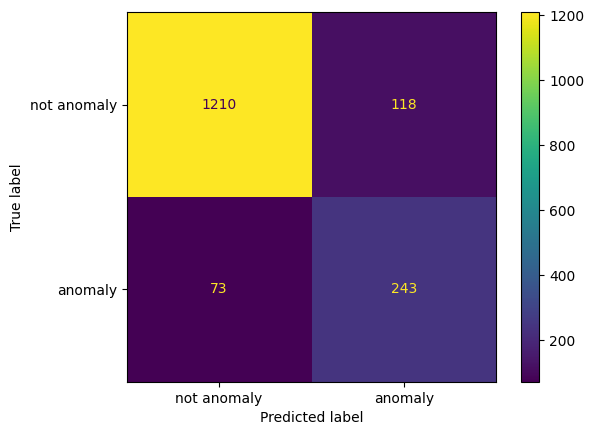

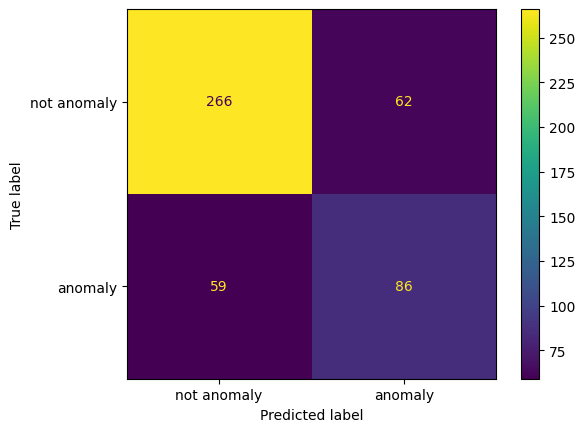

In [177]:
print(f'accu_model confusion matrix:-\n')
ConfusionMatrixDisplay.from_predictions(accu_y_test,accu_y_pred, display_labels=["not anomaly", "anomaly"])

print(f'redm_model confusion matrix:-\n')
ConfusionMatrixDisplay.from_predictions(redm_y_test,redm_y_pred, display_labels=["not anomaly", "anomaly"])

### Decreasing the threshold to 0.3 to increase recall

In [195]:
accu_y_prob = accu_model.predict_proba(accu_X_test)[:, 1]
redm_y_prob = redm_model.predict_proba(redm_X_test)[:, 1]

print(f'accu_y_prob: {accu_y_prob}')
print(f'redm_y_prob: {redm_y_prob}')

accu_y_prob: [0.91415852 0.55855549 0.32625629 ... 0.00563963 0.02954447 0.55104425]
redm_y_prob: [0.86012431 0.41578136 0.83140877 0.14184328 0.13344352 0.11914753
 0.50079471 0.35794911 0.4397884  0.32957243 0.88175916 0.10249484
 0.1219554  0.08294463 0.57385287 0.27800463 0.06573413 0.56722976
 0.24668031 0.06687007 0.30865885 0.42784027 0.4275378  0.08571363
 0.66941773 0.33163386 0.24696459 0.32811928 0.38919783 0.45338624
 0.23517537 0.07629159 0.14232543 0.06796321 0.59758718 0.30764472
 0.36451935 0.15517674 0.83251181 0.46368406 0.54433887 0.34616628
 0.45791338 0.35633426 0.34267785 0.07691698 0.4361134  0.3812549
 0.54918785 0.14610243 0.87474855 0.18322918 0.56961625 0.45712445
 0.22292818 0.39302908 0.07982966 0.99814255 0.25856703 0.23934999
 0.50246776 0.17531785 0.93930521 0.28627032 0.86586894 0.39771582
 0.37096057 0.37181777 0.45179828 0.18236151 0.06780951 0.50669399
 0.51747652 0.66004863 0.58289388 0.34570339 0.30793969 0.48363532
 0.70084776 0.30127548 0.6702356

In [196]:
threshold = 0.3

accu_y_pred = (accu_y_prob > threshold).astype(int)
redm_y_pred = (redm_y_prob > threshold).astype(int)

print(f'after threshold 0.3\n')
print(f'accuracy for accu_model: {accuracy_score(accu_y_test, accu_y_pred)}')
print(f'accuracy for redm_model: {accuracy_score(redm_y_test, redm_y_pred)}')

print(f'classification report for accu_model: \n {classification_report(accu_y_test, accu_y_pred)}')
print(f'classification report for redm_model: \n {classification_report(redm_y_test, redm_y_pred)}')

after threshold 0.3

accuracy for accu_model: 0.8211678832116789
accuracy for redm_model: 0.6617336152219874
classification report for accu_model: 
               precision    recall  f1-score   support

           0       0.96      0.81      0.88      1328
           1       0.52      0.87      0.65       316

    accuracy                           0.82      1644
   macro avg       0.74      0.84      0.77      1644
weighted avg       0.88      0.82      0.84      1644

classification report for redm_model: 
               precision    recall  f1-score   support

           0       0.93      0.55      0.69       328
           1       0.47      0.90      0.62       145

    accuracy                           0.66       473
   macro avg       0.70      0.73      0.66       473
weighted avg       0.79      0.66      0.67       473



accu_model confusion matrix:-

redm_model confusion matrix:-



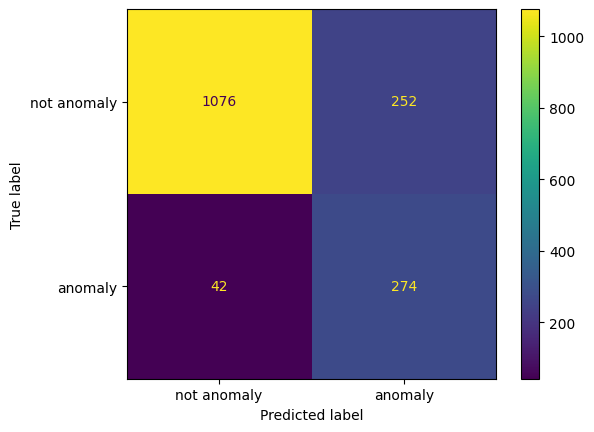

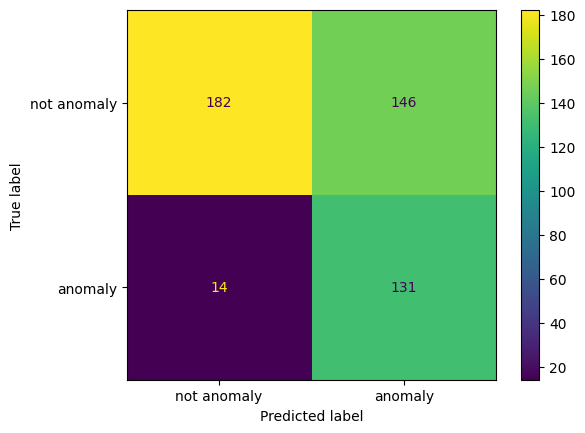

In [197]:
print(f'accu_model confusion matrix:-\n')
ConfusionMatrixDisplay.from_predictions(accu_y_test,accu_y_pred, display_labels=["not anomaly", "anomaly"])

print(f'redm_model confusion matrix:-\n')
ConfusionMatrixDisplay.from_predictions(redm_y_test,redm_y_pred, display_labels=["not anomaly", "anomaly"])

## Scoring

In [198]:
from sklearn.metrics import roc_auc_score
from scipy.stats import ks_2samp

print(f'scores for accrual data')
auc = roc_auc_score(accu_y_test, accu_y_prob)
gini = 2*auc - 1

ks = ks_2samp(
    accu_y_prob[accu_y_test == 0],
    accu_y_prob[accu_y_test == 1]
).statistic

print("AUC :", auc)
print("Gini:", gini)
print("KS  :", ks)

print(f'\nscores for redemption data')
auc = roc_auc_score(redm_y_test, redm_y_prob)
gini = 2*auc - 1

ks = ks_2samp(
    redm_y_prob[redm_y_test == 0],
    redm_y_prob[redm_y_test == 1]
).statistic

print("AUC :", auc)
print("Gini:", gini)
print("KS  :", ks)

scores for accrual data
AUC : 0.9311780349245082
Gini: 0.8623560698490165
KS  : 0.7065254689644654

scores for redemption data
AUC : 0.8132884777123633
Gini: 0.6265769554247267
KS  : 0.4915685449957948


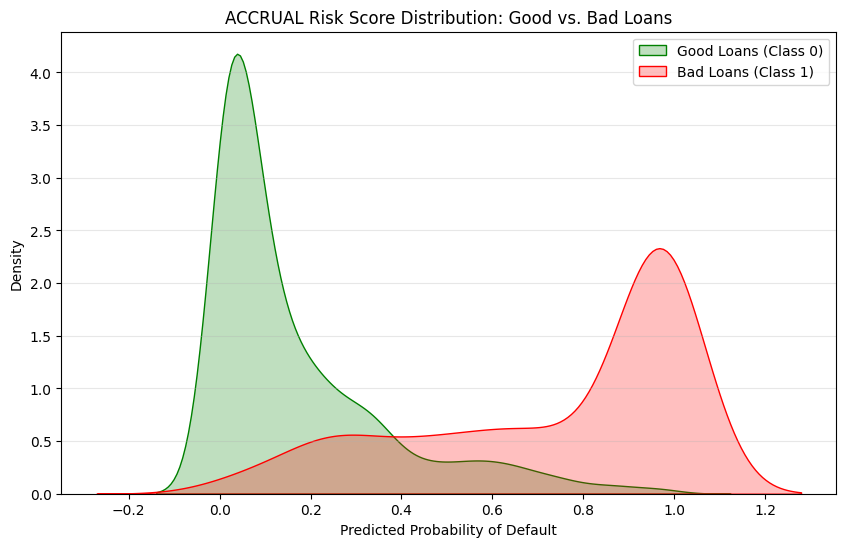

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for the distribution
dist_df = pd.DataFrame({'Probability': accu_y_prob, 'Actual': accu_y_test})

plt.figure(figsize=(10, 6))
sns.kdeplot(data=dist_df[dist_df['Actual'] == 0], x='Probability', label='Good Loans (Class 0)', fill=True, color='green')
sns.kdeplot(data=dist_df[dist_df['Actual'] == 1], x='Probability', label='Bad Loans (Class 1)', fill=True, color='red')

plt.title('ACCRUAL Risk Score Distribution: Good vs. Bad Loans')
plt.xlabel('Predicted Probability of Default')
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.show()

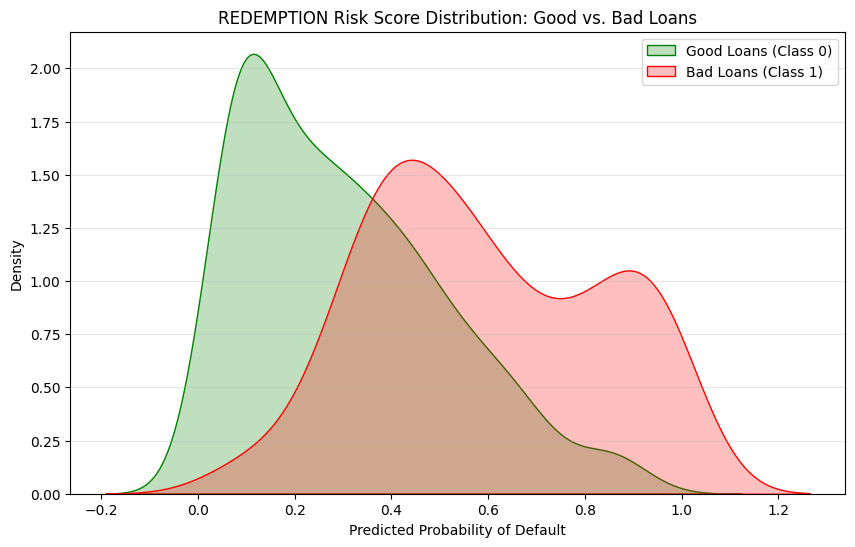

In [202]:
dist_df = pd.DataFrame({'Probability': redm_y_prob, 'Actual': redm_y_test})

plt.figure(figsize=(10, 6))
sns.kdeplot(data=dist_df[dist_df['Actual'] == 0], x='Probability', label='Good Loans (Class 0)', fill=True, color='green')
sns.kdeplot(data=dist_df[dist_df['Actual'] == 1], x='Probability', label='Bad Loans (Class 1)', fill=True, color='red')

plt.title('REDEMPTION Risk Score Distribution: Good vs. Bad Loans')
plt.xlabel('Predicted Probability of Default')
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.show()

### decile

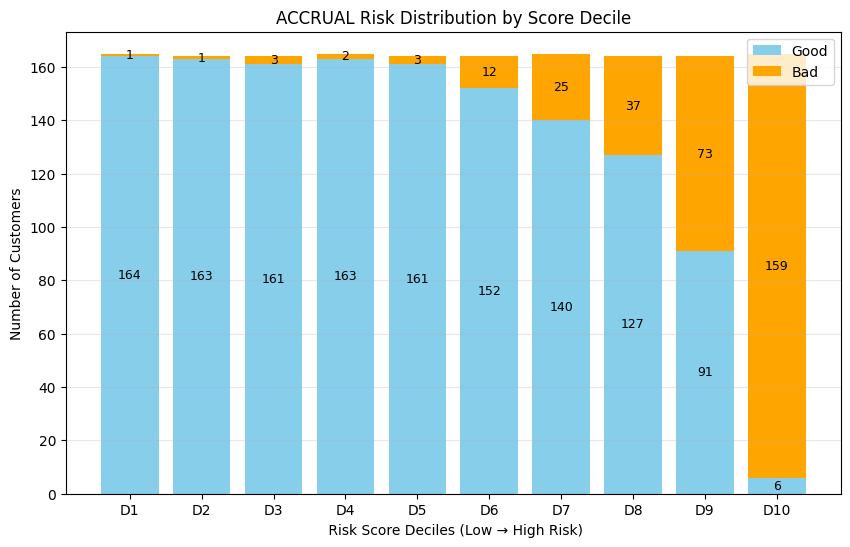

In [206]:
# Build dataframe
dist_df = pd.DataFrame({
    "Probability": accu_y_prob,
    "Actual": accu_y_test
})

# Create deciles
dist_df["score_bin"] = pd.qcut(dist_df["Probability"], 10, duplicates="drop")

# Summarize counts
bin_summary = dist_df.groupby(["score_bin","Actual"]).size().unstack(fill_value=0)
bin_summary["total"] = bin_summary[0] + bin_summary[1]
bin_summary["bad_rate"] = bin_summary[1] / bin_summary["total"]

bin_summary = bin_summary.reset_index()

# Plot
plt.figure(figsize=(10,6))

bars_good = plt.bar(range(len(bin_summary)), bin_summary[0], label="Good", color="skyblue")
bars_bad  = plt.bar(range(len(bin_summary)), bin_summary[1], 
                     bottom=bin_summary[0], label="Bad", color="orange")

# Add labels
for i in range(len(bin_summary)):
    # Good label
    plt.text(i, bin_summary[0][i] / 2, 
             f"{bin_summary[0][i]}", 
             ha="center", va="center", fontsize=9)

    # Bad label
    plt.text(i, bin_summary[0][i] + bin_summary[1][i] / 2, 
             f"{bin_summary[1][i]}", 
             ha="center", va="center", fontsize=9)

# X-axis labels
plt.xticks(range(len(bin_summary)), [f"D{i+1}" for i in range(len(bin_summary))])

plt.xlabel(" Risk Score Deciles (Low → High Risk)")
plt.ylabel("Number of Customers")
plt.title("ACCRUAL Risk Distribution by Score Decile")
plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.show()

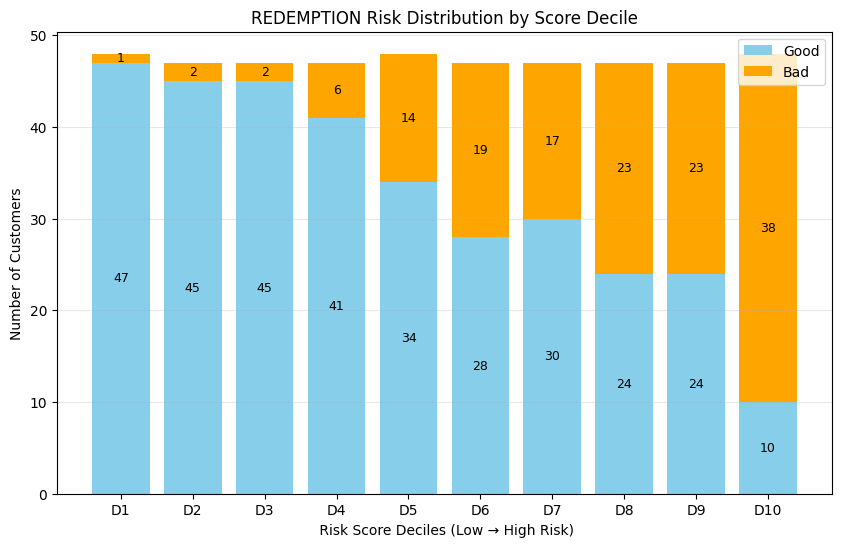

In [207]:
# Build dataframe
dist_df = pd.DataFrame({
    "Probability": redm_y_prob,
    "Actual": redm_y_test
})

# Create deciles
dist_df["score_bin"] = pd.qcut(dist_df["Probability"], 10, duplicates="drop")

# Summarize counts
bin_summary = dist_df.groupby(["score_bin","Actual"]).size().unstack(fill_value=0)
bin_summary["total"] = bin_summary[0] + bin_summary[1]
bin_summary["bad_rate"] = bin_summary[1] / bin_summary["total"]

bin_summary = bin_summary.reset_index()

# Plot
plt.figure(figsize=(10,6))

bars_good = plt.bar(range(len(bin_summary)), bin_summary[0], label="Good", color="skyblue")
bars_bad  = plt.bar(range(len(bin_summary)), bin_summary[1], 
                     bottom=bin_summary[0], label="Bad", color="orange")

# Add labels
for i in range(len(bin_summary)):
    # Good label
    plt.text(i, bin_summary[0][i] / 2, 
             f"{bin_summary[0][i]}", 
             ha="center", va="center", fontsize=9)

    # Bad label
    plt.text(i, bin_summary[0][i] + bin_summary[1][i] / 2, 
             f"{bin_summary[1][i]}", 
             ha="center", va="center", fontsize=9)

# X-axis labels
plt.xticks(range(len(bin_summary)), [f"D{i+1}" for i in range(len(bin_summary))])

plt.xlabel(" Risk Score Deciles (Low → High Risk)")
plt.ylabel("Number of Customers")
plt.title("REDEMPTION Risk Distribution by Score Decile")
plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.show()

In [211]:
# Decile 
result_df = pd.DataFrame({
    "actual": accu_y_test.values,
    "probability": accu_y_prob
})

# Higher probability = higher risk → highest decile = D10
result_df["decile"] = pd.qcut(
    result_df["probability"],
    10,
    labels=["D1","D2","D3","D4","D5","D6","D7","D8","D9","D10"]
)


def assign_action_from_decile(decile):
    if decile in ["D10"]:
        return "Very High Risk"
    elif decile in ["D8","D9"]:
        return "High Risk"
    elif decile in ["D5", "D6", "D7"]:
        return "Medium Risk"
    else:  # D1–D4
        return "Low Risk"

result_df["action"] = result_df["decile"].apply(assign_action_from_decile)

ACTION_ORDER = ["Very High Risk", "High Risk", "Medium Risk", "Low Risk"]

good_df = result_df[result_df["actual"] == 0]

good_table = (
    good_df["action"]
    .value_counts()
    .reindex(ACTION_ORDER, fill_value=0)
    .to_frame("Count")
)

good_table["% of Non-anomalies"] = (good_table["Count"] / good_table["Count"].sum() * 100).round(2)

good_total = pd.DataFrame({
    "Count": [good_table["Count"].sum()],
    "% of Non-anomalies": [100.0]
}, index=["Total"])

good_table_final = pd.concat([good_table, good_total])
print(good_table_final)

ACTION_ORDER1 = ["Very High Risk",  "High Risk", "Medium Risk","Low Risk" ]
bad_df = result_df[result_df["actual"] == 1]

bad_table = (
    bad_df["action"]
    .value_counts()
    .reindex(ACTION_ORDER1, fill_value=0)
    .to_frame("Count")
)

bad_table["% of Anomalies"] = (bad_table["Count"] / bad_table["Count"].sum() * 100).round(2)

bad_total = pd.DataFrame({
    "Count": [bad_table["Count"].sum()],
    "% of Anomalies": [100.0]
}, index=["Total"])

bad_table_final = pd.concat([bad_table, bad_total])
print(bad_table_final)

                Count  % of Non-anomalies
Very High Risk      6                0.45
High Risk         218               16.42
Medium Risk       453               34.11
Low Risk          651               49.02
Total            1328              100.00
                Count  % of Anomalies
Very High Risk    159           50.32
High Risk         110           34.81
Medium Risk        40           12.66
Low Risk            7            2.22
Total             316          100.00


In [212]:
# Decile 
result_df = pd.DataFrame({
    "actual": redm_y_test.values,
    "probability": redm_y_prob
})

# Higher probability = higher risk → highest decile = D10
result_df["decile"] = pd.qcut(
    result_df["probability"],
    10,
    labels=["D1","D2","D3","D4","D5","D6","D7","D8","D9","D10"]
)


def assign_action_from_decile(decile):
    if decile in ["D10"]:
        return "Very High Risk"
    elif decile in ["D8","D9"]:
        return "High Risk"
    elif decile in ["D5", "D6", "D7"]:
        return "Medium Risk"
    else:  # D1–D4
        return "Low Risk"

result_df["action"] = result_df["decile"].apply(assign_action_from_decile)

ACTION_ORDER = ["Very High Risk", "High Risk", "Medium Risk", "Low Risk"]

good_df = result_df[result_df["actual"] == 0]

good_table = (
    good_df["action"]
    .value_counts()
    .reindex(ACTION_ORDER, fill_value=0)
    .to_frame("Count")
)

good_table["% of Non-anomalies"] = (good_table["Count"] / good_table["Count"].sum() * 100).round(2)

good_total = pd.DataFrame({
    "Count": [good_table["Count"].sum()],
    "% of Non-anomalies": [100.0]
}, index=["Total"])

good_table_final = pd.concat([good_table, good_total])
print(good_table_final)

ACTION_ORDER1 = ["Very High Risk",  "High Risk", "Medium Risk","Low Risk" ]
bad_df = result_df[result_df["actual"] == 1]

bad_table = (
    bad_df["action"]
    .value_counts()
    .reindex(ACTION_ORDER1, fill_value=0)
    .to_frame("Count")
)

bad_table["% of Anomalies"] = (bad_table["Count"] / bad_table["Count"].sum() * 100).round(2)

bad_total = pd.DataFrame({
    "Count": [bad_table["Count"].sum()],
    "% of Anomalies": [100.0]
}, index=["Total"])

bad_table_final = pd.concat([bad_table, bad_total])
print(bad_table_final)

                Count  % of Non-anomalies
Very High Risk     10                3.05
High Risk          48               14.63
Medium Risk        92               28.05
Low Risk          178               54.27
Total             328              100.00
                Count  % of Anomalies
Very High Risk     38           26.21
High Risk          46           31.72
Medium Risk        50           34.48
Low Risk           11            7.59
Total             145          100.00


In [ ]:
accu_best_model.save_model("accu_model.cbm")
redm_best_model.save_model("redm_model.cbm")

### Increase scale weight and decrease threshold

In [183]:
accu_model = CatBoostClassifier(
    class_weights=[1, accu_scale_weight * 2]
)

redm_model = CatBoostClassifier(
    class_weights=[1, redm_scale_weight * 2]
)

In [184]:
accu_model.fit(accu_X_train, accu_y_train, cat_features=cal_cols_accu.tolist())

Learning rate set to 0.023024
0:	learn: 0.6870857	total: 65.6ms	remaining: 1m 5s
1:	learn: 0.6810142	total: 89.6ms	remaining: 44.7s
2:	learn: 0.6746525	total: 120ms	remaining: 39.8s
3:	learn: 0.6646047	total: 183ms	remaining: 45.5s
4:	learn: 0.6569157	total: 257ms	remaining: 51.1s
5:	learn: 0.6478154	total: 330ms	remaining: 54.7s
6:	learn: 0.6430976	total: 386ms	remaining: 54.8s
7:	learn: 0.6383233	total: 409ms	remaining: 50.7s
8:	learn: 0.6343843	total: 433ms	remaining: 47.6s
9:	learn: 0.6267064	total: 500ms	remaining: 49.5s
10:	learn: 0.6230878	total: 529ms	remaining: 47.6s
11:	learn: 0.6144992	total: 602ms	remaining: 49.6s
12:	learn: 0.6071013	total: 653ms	remaining: 49.5s
13:	learn: 0.6002844	total: 741ms	remaining: 52.2s
14:	learn: 0.5915866	total: 813ms	remaining: 53.4s
15:	learn: 0.5862526	total: 868ms	remaining: 53.4s
16:	learn: 0.5802963	total: 931ms	remaining: 53.8s
17:	learn: 0.5747233	total: 1s	remaining: 54.6s
18:	learn: 0.5723679	total: 1.03s	remaining: 53.1s
19:	learn: 0

In [185]:
redm_model.fit(redm_X_train, redm_y_train, cat_features=cal_cols_redm.tolist())

Learning rate set to 0.013523
0:	learn: 0.6896910	total: 143ms	remaining: 2m 22s
1:	learn: 0.6858263	total: 253ms	remaining: 2m 6s
2:	learn: 0.6802163	total: 339ms	remaining: 1m 52s
3:	learn: 0.6777779	total: 375ms	remaining: 1m 33s
4:	learn: 0.6757589	total: 406ms	remaining: 1m 20s
5:	learn: 0.6736729	total: 428ms	remaining: 1m 10s
6:	learn: 0.6716276	total: 451ms	remaining: 1m 3s
7:	learn: 0.6703847	total: 466ms	remaining: 57.7s
8:	learn: 0.6682019	total: 509ms	remaining: 56s
9:	learn: 0.6647919	total: 577ms	remaining: 57.1s
10:	learn: 0.6606348	total: 636ms	remaining: 57.2s
11:	learn: 0.6557299	total: 692ms	remaining: 57s
12:	learn: 0.6516001	total: 756ms	remaining: 57.4s
13:	learn: 0.6498555	total: 808ms	remaining: 56.9s
14:	learn: 0.6454057	total: 866ms	remaining: 56.9s
15:	learn: 0.6413282	total: 905ms	remaining: 55.7s
16:	learn: 0.6393870	total: 964ms	remaining: 55.8s
17:	learn: 0.6359175	total: 1.03s	remaining: 56.1s
18:	learn: 0.6345244	total: 1.09s	remaining: 56.2s
19:	learn:

In [186]:
accu_y_prob = accu_model.predict_proba(accu_X_test)[:, 1]
redm_y_prob = redm_model.predict_proba(redm_X_test)[:, 1]

threshold = 0.3

accu_y_pred = (accu_y_prob > threshold).astype(int)
redm_y_pred = (redm_y_prob > threshold).astype(int)

In [187]:
print(f'accuracy for accu_model: {accuracy_score(accu_y_test, accu_y_pred)}')
print(f'accuracy for redm_model: {accuracy_score(redm_y_test, redm_y_pred)}')

print(f'classification report for accu_model: \n {classification_report(accu_y_test, accu_y_pred)}')
print(f'classification report for redm_model: \n {classification_report(redm_y_test, redm_y_pred)}')

accuracy for accu_model: 0.7554744525547445
accuracy for redm_model: 0.572938689217759
classification report for accu_model: 
               precision    recall  f1-score   support

           0       0.98      0.71      0.82      1328
           1       0.44      0.94      0.60       316

    accuracy                           0.76      1644
   macro avg       0.71      0.83      0.71      1644
weighted avg       0.88      0.76      0.78      1644

classification report for redm_model: 
               precision    recall  f1-score   support

           0       0.96      0.40      0.57       328
           1       0.41      0.96      0.58       145

    accuracy                           0.57       473
   macro avg       0.69      0.68      0.57       473
weighted avg       0.79      0.57      0.57       473



accu_model confusion matrix:-

redm_model confusion matrix:-



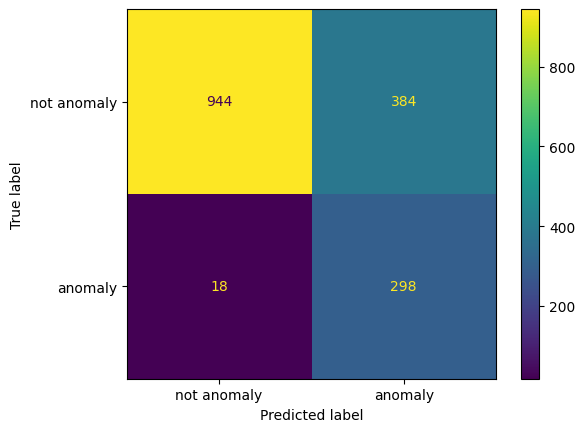

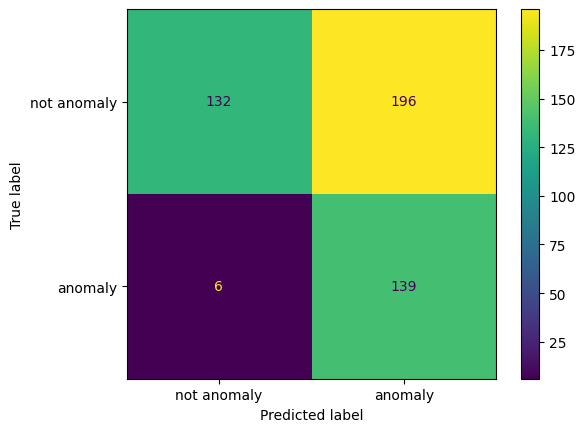

In [188]:
print(f'accu_model confusion matrix:-\n')
ConfusionMatrixDisplay.from_predictions(accu_y_test,accu_y_pred, display_labels=["not anomaly", "anomaly"])

print(f'redm_model confusion matrix:-\n')
ConfusionMatrixDisplay.from_predictions(redm_y_test,redm_y_pred, display_labels=["not anomaly", "anomaly"])

### Train with more hyperparameters 

In [38]:
param_grid = {
    "depth": [4, 5, 6, 7, 8],
    "learning_rate": [0.01, 0.03, 0.05, 0.07, 0.1],
    "iterations": [300, 500, 700, 1000],
    "l2_leaf_reg": [1, 3, 5, 7, 9],
    "border_count": [32, 64, 128],
    "bagging_temperature": [0, 0.5, 1, 3, 5],
    "random_strength": [0.5, 1, 2, 5]
}

In [42]:
# accu_random_search = RandomizedSearchCV(
#     estimator=CatBoostClassifier(
#     eval_metric="AUC",
#     loss_function="Logloss",
#     verbose=0,
#     class_weights=[1, accu_scale_weight]
# ),
#     param_distributions=param_grid,
#     n_iter=30,
#     scoring="average_precision",
#     cv=3,
#     verbose=2,
#     random_state=42,
#     n_jobs=1
# )

In [51]:
train_pool = Pool(
    data=accu_X_train,
    label=accu_y_train,
    cat_features=cal_cols_accu.tolist()
)

model = CatBoostClassifier(
    eval_metric="AUC",
    loss_function="Logloss",
    verbose=0,
    class_weights=[1, accu_scale_weight]
)
accu_model = model.randomized_search(param_grid, X=train_pool, cv=3, n_iter=30, stratified=True, verbose=False)


bestTest = 0.9277220697
bestIteration = 37

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.8992488371
bestIteration = 289

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.9267472781
bestIteration = 259

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.92007784
bestIteration = 434

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.9277507401
bestIteration = 220

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.9018112488
bestIteration = 685

Metric AUC is not calculated on train by default. To calc

In [54]:
accu_best_params = accu_model['params']
print(accu_best_params)

{'border_count': 128, 'bagging_temperature': 0, 'random_strength': 0.5, 'depth': 5, 'learning_rate': 0.07, 'l2_leaf_reg': 5, 'iterations': 1000}


In [53]:
train_pool_2 = Pool(
    data=redm_X_train,
    label=redm_y_train,
    cat_features=cal_cols_redm.tolist()
)

model_2 = CatBoostClassifier(
    eval_metric="AUC",
    loss_function="Logloss",
    verbose=0,
    thread_count=-1,
    class_weights=[1, redm_scale_weight]
)

redm_model = model_2.randomized_search(param_grid, X=train_pool_2, cv=3, n_iter=30, stratified=True, verbose=False)


bestTest = 0.8268015171
bestIteration = 10

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.7828198816
bestIteration = 297

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.8203473285
bestIteration = 166

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.8261028678
bestIteration = 471

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.8211457848
bestIteration = 156

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.7993878502
bestIteration = 697

Metric AUC is not calculated on train by default. To ca

In [55]:
redm_best_params = redm_model['params']
print(redm_best_params)

{'border_count': 128, 'bagging_temperature': 5, 'random_strength': 5, 'depth': 4, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 300}


In [58]:
accu_best_model = CatBoostClassifier(**accu_best_params, verbose=0)
accu_best_model.fit(accu_X_train, accu_y_train, cat_features=cal_cols_accu.tolist())

In [59]:
redm_best_model = CatBoostClassifier(**redm_best_params)
redm_best_model.fit(redm_X_train, redm_y_train, cat_features=cal_cols_redm.tolist())

0:	learn: 0.6782760	total: 13.6ms	remaining: 4.07s
1:	learn: 0.6611413	total: 27.3ms	remaining: 4.07s
2:	learn: 0.6516503	total: 45.3ms	remaining: 4.48s
3:	learn: 0.6440429	total: 47.1ms	remaining: 3.48s
4:	learn: 0.6284458	total: 68.2ms	remaining: 4.03s
5:	learn: 0.6234092	total: 89.8ms	remaining: 4.4s
6:	learn: 0.6194247	total: 95.3ms	remaining: 3.99s
7:	learn: 0.6162151	total: 101ms	remaining: 3.67s
8:	learn: 0.6090979	total: 121ms	remaining: 3.91s
9:	learn: 0.6012875	total: 142ms	remaining: 4.13s
10:	learn: 0.5989713	total: 164ms	remaining: 4.3s
11:	learn: 0.5974334	total: 184ms	remaining: 4.42s
12:	learn: 0.5916070	total: 206ms	remaining: 4.55s
13:	learn: 0.5774777	total: 227ms	remaining: 4.64s
14:	learn: 0.5730829	total: 250ms	remaining: 4.76s
15:	learn: 0.5689160	total: 274ms	remaining: 4.87s
16:	learn: 0.5664425	total: 287ms	remaining: 4.77s
17:	learn: 0.5626873	total: 308ms	remaining: 4.82s
18:	learn: 0.5589344	total: 327ms	remaining: 4.84s
19:	learn: 0.5513955	total: 347ms	re

In [60]:
accu_y_pred = accu_best_model.predict(accu_X_test)
redm_y_pred = redm_best_model.predict(redm_X_test)

print(f'accuracy for accu_model: {accuracy_score(accu_y_test, accu_y_pred)}')
print(f'accuracy for redm_model: {accuracy_score(redm_y_test, redm_y_pred)}')

accuracy for accu_model: 0.9093673965936739
accuracy for redm_model: 0.7758985200845666


In [61]:
print(f'classification report for accu_model: \n {classification_report(accu_y_test, accu_y_pred)}')
print(f'classification report for redm_model: \n {classification_report(redm_y_test, redm_y_pred)}')

classification report for accu_model: 
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      1328
           1       0.87      0.62      0.73       316

    accuracy                           0.91      1644
   macro avg       0.89      0.80      0.84      1644
weighted avg       0.91      0.91      0.90      1644

classification report for redm_model: 
               precision    recall  f1-score   support

           0       0.79      0.93      0.85       328
           1       0.72      0.43      0.54       145

    accuracy                           0.78       473
   macro avg       0.76      0.68      0.70       473
weighted avg       0.77      0.78      0.76       473



accu_model confusion matrix:-

redm_model confusion matrix:-



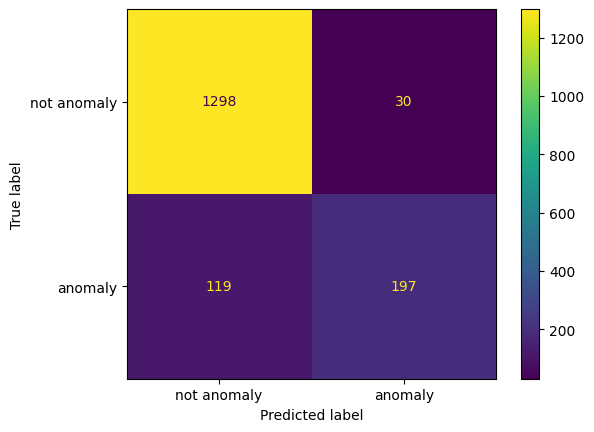

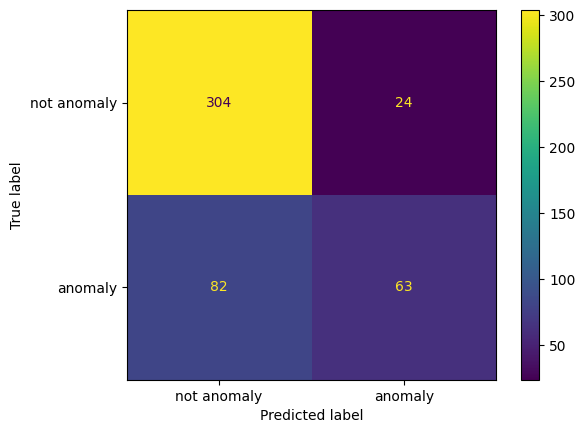

In [62]:
print(f'accu_model confusion matrix:-\n')
ConfusionMatrixDisplay.from_predictions(accu_y_test,accu_y_pred, display_labels=["not anomaly", "anomaly"])

print(f'redm_model confusion matrix:-\n')
ConfusionMatrixDisplay.from_predictions(redm_y_test,redm_y_pred, display_labels=["not anomaly", "anomaly"])

In [189]:
# Create consolidated CSV files with all metrics in one file per model
import os

output_dir = 'model_predictions'
os.makedirs(output_dir, exist_ok=True)

def create_consolidated_report(y_test, y_pred, model_name):
    """
    Create a consolidated CSV with predictions, classification report, and confusion matrix
    """
    from sklearn.metrics import classification_report, confusion_matrix
    
    # 1. Predictions section
    predictions_df = pd.DataFrame({
        'actual': y_test.values,
        'predicted': y_pred,
        'match': (y_test.values == y_pred).astype(int)
    })
    
    # 2. Classification Report
    class_report = classification_report(y_test, y_pred, output_dict=True)
    class_report_df = pd.DataFrame(class_report).transpose()
    
    # 3. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(
        cm,
        index=['Actual Negative', 'Actual Positive'],
        columns=['Predicted Negative', 'Predicted Positive']
    )
    
    # Create consolidated dataframe
    consolidated = []
    
    # Add title
    consolidated.append(pd.Series({'Section': f'{model_name} Model - Complete Report', 'Value': ''}))
    consolidated.append(pd.Series({'Section': '', 'Value': ''}))
    
    # Add predictions
    consolidated.append(pd.Series({'Section': 'PREDICTIONS', 'Value': ''}))
    consolidated.append(pd.Series({'Section': f'Total Predictions: {len(predictions_df)}', 'Value': ''}))
    predictions_df_with_section = predictions_df.copy()
    for idx in predictions_df_with_section.index:
        consolidated.append(pd.Series({'Section': 'actual', f'Value_{idx}': predictions_df_with_section.loc[idx, 'actual']}))
    
    # Better approach: concatenate differently formatted sections
    # Create string representation for compact format
    predictions_str = predictions_df.to_string()
    class_report_str = class_report_df.to_string()
    cm_str = cm_df.to_string()
    
    # Create consolidated text
    consolidated_text = f"""
{model_name} MODEL - CONSOLIDATED REPORT
{'='*80}

PREDICTIONS ({len(predictions_df)} total)
{'-'*80}
{predictions_str}

CLASSIFICATION REPORT
{'-'*80}
{class_report_str}

CONFUSION MATRIX
{'-'*80}
{cm_str}
"""
    
    # Export as CSV with a different structure - using rows for different sections
    output_file = os.path.join(output_dir, f'{model_name}_consolidated_report.csv')
    
    with open(output_file, 'w') as f:
        f.write(consolidated_text)
    
    # Also create a structured CSV version
    csv_file = os.path.join(output_dir, f'{model_name}_full_report.csv')
    
    # Write structured CSV
    with open(csv_file, 'w') as f:
        # Write header
        f.write(f'REPORT_TYPE,VALUE_1,VALUE_2,VALUE_3,VALUE_4\n')
        f.write(f'Model,{model_name},,\n')
        f.write(f'Total Predictions,{len(predictions_df)},,\n')
        f.write('\n')
        
        # Write predictions
        f.write('PREDICTIONS SECTION\n')
        f.write('Index,Actual,Predicted,Match\n')
        for idx, row in predictions_df.iterrows():
            f.write(f'{idx},{row["actual"]},{row["predicted"]},{row["match"]}\n')
        
        f.write('\n')
        f.write('CLASSIFICATION REPORT\n')
        f.write('Metric,Precision,Recall,F1-Score,Support\n')
        for idx, row in class_report_df.iterrows():
            f.write(f'{idx},{row["precision"]:.4f},{row["recall"]:.4f},{row["f1-score"]:.4f},{row["support"]:.0f}\n')
        
        f.write('\n')
        f.write('CONFUSION MATRIX\n')
        f.write('Actual,Predicted Negative,Predicted Positive\n')
        for idx, row in cm_df.iterrows():
            f.write(f'{idx},{row["Predicted Negative"]},{row["Predicted Positive"]}\n')
    
    return output_file, csv_file

# Export for Accrual Model
print("=" * 80)
print("CREATING CONSOLIDATED REPORT FOR ACCRUAL MODEL")
print("=" * 80)
accu_text_file, accu_csv_file = create_consolidated_report(accu_y_test, accu_y_pred, 'accu')
print(f"✓ Text Report: {accu_text_file}")
print(f"✓ CSV Report: {accu_csv_file}")

# Export for Redeem Model
print("\n" + "=" * 80)
print("CREATING CONSOLIDATED REPORT FOR REDEEM MODEL")
print("=" * 80)
redm_text_file, redm_csv_file = create_consolidated_report(redm_y_test, redm_y_pred, 'redm')
print(f"✓ Text Report: {redm_text_file}")
print(f"✓ CSV Report: {redm_csv_file}")

print("\n" + "=" * 80)
print("FINAL SUMMARY")
print("=" * 80)
print(f"Directory: {output_dir}/")
print(f"\nConsolidated CSV Files (2 total):")
print(f"  1. accu_full_report.csv - Accrual model complete report")
print(f"  2. redm_full_report.csv - Redeem model complete report")
print(f"\nText Reports:")
print(f"  1. accu_consolidated_report.csv - Accrual model (text format)")
print(f"  2. redm_consolidated_report.csv - Redeem model (text format)")
print(f"\nEach file contains:")
print(f"  - All predictions with actual vs predicted values")
print(f"  - Classification report (Precision, Recall, F1-Score, Support)")
print(f"  - Confusion matrix in tabular format")

CREATING CONSOLIDATED REPORT FOR ACCRUAL MODEL
✓ Text Report: model_predictions\accu_consolidated_report.csv
✓ CSV Report: model_predictions\accu_full_report.csv

CREATING CONSOLIDATED REPORT FOR REDEEM MODEL
✓ Text Report: model_predictions\redm_consolidated_report.csv
✓ CSV Report: model_predictions\redm_full_report.csv

FINAL SUMMARY
Directory: model_predictions/

Consolidated CSV Files (2 total):
  1. accu_full_report.csv - Accrual model complete report
  2. redm_full_report.csv - Redeem model complete report

Text Reports:
  1. accu_consolidated_report.csv - Accrual model (text format)
  2. redm_consolidated_report.csv - Redeem model (text format)

Each file contains:
  - All predictions with actual vs predicted values
  - Classification report (Precision, Recall, F1-Score, Support)
  - Confusion matrix in tabular format
